In [1]:
!pip install lifelines
!pip install scipy
!pip install scikit-survival
!pip install statsmodels
!pip install pycox
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 6.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=e2f4f52d2ddf21d1569778953bfca290db224e4f829b2feabfd6248e459f3867
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


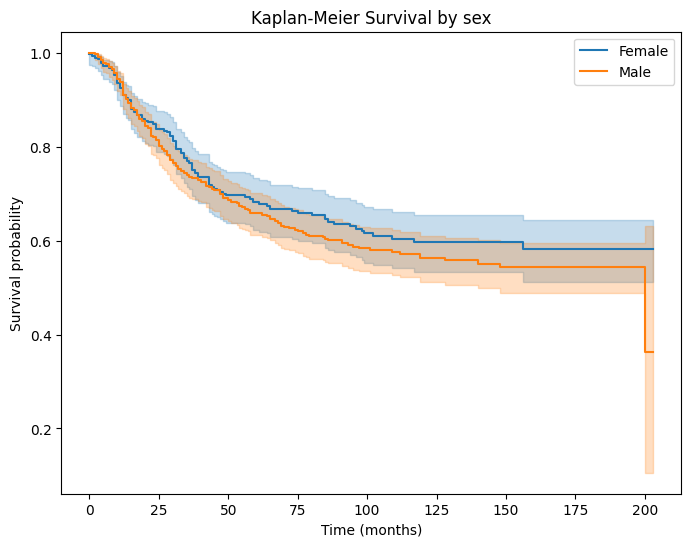

In [7]:
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
df = pd.read_excel("df.xlsx")
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Assume your DataFrame has 'surviva_months', 'status', 'sex'
kmf = KaplanMeierFitter()

# Unique groups in 'sex' column
groups = df['sex'].unique()

plt.figure(figsize=(8,6))

for group in groups:
    mask = df['sex'] == group
    kmf.fit(durations=df.loc[mask, 'surviva_months'],
            event_observed=df.loc[mask, 'status'],
            label=group)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Survival by sex")
plt.xlabel("Time (months)")
plt.ylabel("Survival probability")
plt.show()



In [8]:
# encoding
X = df.drop(columns=["surviva_months", "status"])
X_enc = pd.get_dummies(X, drop_first=True)
y = df[["surviva_months", "status"]].copy()
y["status"] = y["status"].astype(int)

df_enc = pd.concat([y, X_enc], axis=1)



In [9]:
# proportional cox hazard model
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)  # ridge penalty helps convergence
cph.fit(df_enc, duration_col="surviva_months", event_col="status", robust=True)
cph.print_summary()
random_state=42

model,lifelines.CoxPHFitter
duration col,'surviva_months'
event col,'status'
penalizer,0.1
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,726
number of events observed,294
partial log-likelihood,-1753.59
time fit was run,2025-09-02 03:37:06 UTC


In [10]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.model_selection import train_test_split

# Prepare survival object
y = Surv.from_dataframe("status", "surviva_months", df_enc)

X_train, X_test, y_train, y_test = train_test_split(
    df_enc.drop(columns=["surviva_months", "status"]),
    y,
    test_size=0.2,
    random_state=random_state
)


In [11]:
rsf = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=15,
    n_jobs=-1,
    random_state=random_state
)

rsf.fit(X_train, y_train)

# Concordance index
print("C-index:", rsf.score(X_test, y_test))

C-index: 0.6906052393857272


In [12]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

gbsa = GradientBoostingSurvivalAnalysis(
    learning_rate=0.05,
    n_estimators=200,
    random_state=random_state
)
gbsa.fit(X_train, y_train)

print("C-index:", gbsa.score(X_test, y_test))


C-index: 0.7036284251731406


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

# Features
X = df_enc.drop(columns=["surviva_months", "status"]).values.astype("float32")

# Labels
durations = df_enc["surviva_months"].values.astype("float32")
events = df_enc["status"].values.astype("int32")

# Combine into one array with 2 columns (duration, event)
y = np.vstack([durations, events]).T

# Now split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

# Extract back durations & events for pycox
durations_train, events_train = y_train[:,0], y_train[:,1]
durations_test, events_test = y_test[:,0], y_test[:,1]

In [21]:
import numpy as np
from sksurv.util import Surv

def to_structured_y(y_array):
    """
    Convert a (n_samples, 2) array into scikit-survival structured array.
    Assumes: [:,0] = time, [:,1] = event (0=censored, 1=event).
    """
    # Ensure y_array is a numpy array before accessing columns
    y_array = np.asarray(y_array)
    times = y_array[:, 0].astype(float)
    events = y_array[:, 1].astype(bool)
    return np.array(list(zip(events, times)), dtype=[("event", "bool"), ("time", "f8")])
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
y_train_time = y_train[:, 0].astype(float)
y_train_event = y_train[:, 1].astype(bool)

y_test_time = y_test[:, 0].astype(float)
y_test_event = y_test[:, 1].astype(bool)



# Convert train/test targets
# Use y_train_pycox and y_test_pycox from the second split
y_train_struct = to_structured_y(y_train)
y_test_struct  = to_structured_y(y_test)

print(y_train_struct[:5])
print(y_test_struct[:5])
print(y_train_struct.dtype)

[( True,  88.) (False, 125.) ( True,  27.) (False,  77.) (False, 116.)]
[( True,  10.) (False, 166.) (False, 147.) (False, 111.) (False, 119.)]
[('event', '?'), ('time', '<f8')]


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score
)
from sksurv.util import Surv
from sklearn.metrics import confusion_matrix

def extended_survival_evaluation(model, X_train, y_train_struct, X_test, y_test_struct, fixed_time=None):
    results = {}

    # --- 1. Harrell’s C-index (default .score) ---
    results["Harrell c-index"] = model.score(X_test, y_test_struct)

    # --- 1. Uno’s C-index (more robust to censoring) ---
    uno_cindex = concordance_index_ipcw(y_train_struct, y_test_struct,
                                        model.predict(X_test), tau=None)
    results["Uno c-index"] = uno_cindex[0]

    # --- 2. Integrated Brier Score ---
    surv_funcs = model.predict_survival_function(X_test)
    time_grid = np.percentile(y_test_struct["time"], np.linspace(10, 90, 10))
    surv_matrix = np.asarray([[fn(t) for t in time_grid] for fn in surv_funcs])
    ibs = integrated_brier_score(y_train_struct, y_test_struct, surv_matrix, time_grid)
    results["Integrated Brier Score"] = ibs

    # --- 3. Time-dependent AUC (already had) ---
    risk_scores = 1 - surv_matrix
    td_auc, mean_auc = cumulative_dynamic_auc(y_train_struct, y_test_struct, risk_scores, time_grid)
    results["Time-dependent AUC (per time)"] = td_auc
    results["Mean AUC"] = mean_auc

    # --- 3. Classification-style metrics at fixed time ---
    if fixed_time is None:
        fixed_time = np.median(y_test_struct["time"])

    preds_at_time = np.array([fn(fixed_time) for fn in surv_funcs])  # survival prob
    risk_at_time = 1 - preds_at_time  # event risk

    # Define "event by fixed_time" ground truth
    y_true = (y_test_struct["event"]) & (y_test_struct["time"] <= fixed_time)

    # Threshold at median risk
    threshold = np.median(risk_at_time)
    y_pred = risk_at_time >= threshold

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn + 1e-10)
    specificity = tn / (tn + fp + 1e-10)
    ppv = tp / (tp + fp + 1e-10)
    npv = tn / (tn + fn + 1e-10)

    results["Fixed-time metrics"] = {
        "Time": fixed_time,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "PPV": ppv,
        "NPV": npv
    }

    # --- 5. Explained variance (pseudo-R²: 1 - IBS/variance of null model) ---
    null_surv = np.repeat(np.mean(y_train_struct["event"]), len(time_grid))
    null_matrix = np.tile(null_surv, (len(y_test_struct), 1))
    null_ibs = integrated_brier_score(y_train_struct, y_test_struct, null_matrix, time_grid)
    r2 = 1 - ibs / null_ibs
    results["Explained variance (pseudo-R²)"] = r2

    return results, (surv_funcs, time_grid, preds_at_time, risk_at_time)


# 🔹 Calibration plot function
def calibration_plot(y_test_struct, preds_at_time, fixed_time, n_bins=5):
    """
    Plot predicted survival probability vs observed KM survival at fixed_time
    """
    from lifelines import KaplanMeierFitter

    # Bin patients by predicted survival probability
    bins = np.linspace(0, 1, n_bins+1)
    bin_ids = np.digitize(preds_at_time, bins) - 1

    obs_surv, pred_surv = [], []
    kmf = KaplanMeierFitter()

    for b in range(n_bins):
        idx = bin_ids == b
        if np.sum(idx) < 5:
            continue
        kmf.fit(y_test_struct["time"][idx], y_test_struct["event"][idx])
        obs_surv.append(kmf.survival_function_at_times(fixed_time).values[0])
        pred_surv.append(np.mean(preds_at_time[idx]))

    plt.plot(pred_surv, obs_surv, "o-", label=f"Calibration at {fixed_time:.1f}")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("Predicted survival probability")
    plt.ylabel("Observed KM survival")
    plt.legend()
    plt.title("Calibration Plot")
    plt.show()


# rsf

{'Harrell c-index': np.float64(0.6906052393857272), 'Uno c-index': np.float64(0.6614586679544658), 'Integrated Brier Score': np.float64(0.19625187299673416), 'Time-dependent AUC (per time)': array([0.59331478, 0.74288951, 0.73633221, 0.75111012, 0.77547996,
       0.75231366, 0.76433074, 0.77085588, 0.72212224, 0.68601718]), 'Mean AUC': np.float64(0.71343056761813), 'Fixed-time metrics': {'Time': 12, 'Sensitivity': np.float64(0.5714285714244898), 'Specificity': np.float64(0.5075757575753731), 'PPV': np.float64(0.10958904109574029), 'NPV': np.float64(0.9178082191768249)}, 'Explained variance (pseudo-R²)': np.float64(0.3301308177561669)}


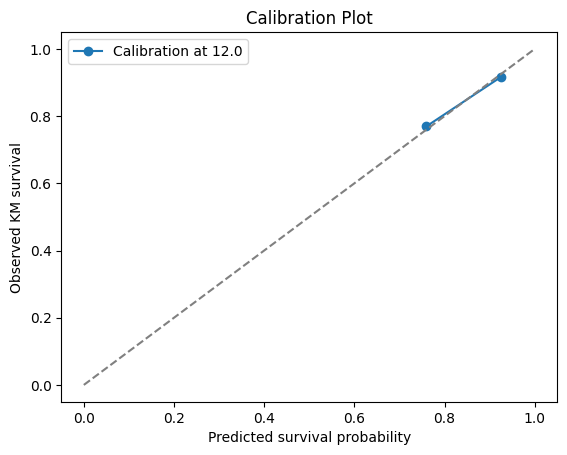

In [23]:
results, (surv_funcs, time_grid, preds_at_time, risk_at_time) = extended_survival_evaluation(
    rsf, X_train, y_train_struct, X_test, y_test_struct, fixed_time=12
)

print(results)

# Plot calibration at 12 months
calibration_plot(y_test_struct, preds_at_time, fixed_time=12)


# gbsa

{'Harrell c-index': np.float64(0.7036284251731406), 'Uno c-index': np.float64(0.6846790313018617), 'Integrated Brier Score': np.float64(0.18910756363658546), 'Time-dependent AUC (per time)': array([0.67237   , 0.76305273, 0.76022297, 0.74970896, 0.79303695,
       0.76937698, 0.77223993, 0.7722067 , 0.71492046, 0.7355887 ]), 'Mean AUC': np.float64(0.7409547279218105), 'Fixed-time metrics': {'Time': 12, 'Sensitivity': np.float64(0.7142857142806123), 'Specificity': np.float64(0.5227272727268768), 'PPV': np.float64(0.13698630136967535), 'NPV': np.float64(0.9452054794507599)}, 'Explained variance (pseudo-R²)': np.float64(0.35451658588006874)}


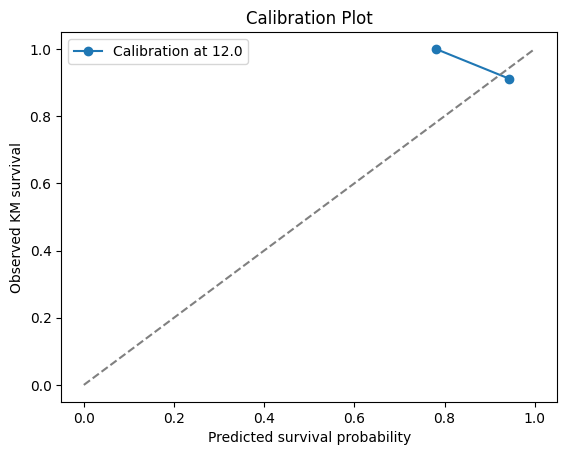

In [24]:
results, (surv_funcs, time_grid, preds_at_time, risk_at_time) = extended_survival_evaluation(
    gbsa, X_train, y_train_struct, X_test, y_test_struct, fixed_time=12
)

print(results)

# Plot calibration at 12 months
calibration_plot(y_test_struct, preds_at_time, fixed_time=12)


In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X is still the DataFrame before converting to numpy array

# scaling
X_scaled_df = pd.DataFrame(StandardScaler().fit_transform(X_enc), columns=X_enc.columns)


# Convert bool → int for VIF calculation (operate on a copy)
X_numeric_for_vif = X_scaled_df.copy()
for col in X_numeric_for_vif.select_dtypes(include=["bool"]).columns:
    X_numeric_for_vif[col] = X_numeric_for_vif[col].astype(int)

# Convert everything else to numeric
for col in X_numeric_for_vif.columns:
    X_numeric_for_vif[col] = pd.to_numeric(X_numeric_for_vif[col], errors="coerce")

# Handle NaN/inf
X_numeric_for_vif = X_numeric_for_vif.replace([np.inf, -np.inf], np.nan)
X_numeric_for_vif = X_numeric_for_vif.dropna(axis=1, how="all")
X_numeric_for_vif = X_numeric_for_vif.fillna(0)


print("Data types for VIF calculation:")
print(X_numeric_for_vif.dtypes.head())

print("\nVIF Calculation:")
vif = pd.DataFrame()
vif["feature"] = X_numeric_for_vif.columns
# Ensure the input to variance_inflation_factor is float type
vif["VIF"] = [variance_inflation_factor(X_numeric_for_vif.values.astype(float), i)
              for i in range(X_numeric_for_vif.shape[1])]

print(vif.sort_values("VIF", ascending=False))

# Create a list of all columns to be dropped due to high or infinite VIF
# Use the columns from the VIF calculation
columns_to_drop_vif = vif[vif['VIF'] > 30]['feature'].tolist() # Example threshold, adjust as needed
# Add specific columns to drop if needed, being careful not to duplicate
specific_columns_to_drop = [
    'AJCC_T_T2b',
    'AJCC_Stage_IV',
    'AJCC_M_M1',
    'primary_site_C40.2-Long bones of lower limb and associated joints',
    'primary_site_C41.4-Pelvic bones, sacrum, coccyx and associated joints',
    'primary_site_C41.3-Rib, sternum, clavicle and associated joints',
    'primary_site_C40.0-Long bones: upper limb, scapula, and associated joints',
    'primary_site_C41.2-Vertebral column',
    'primary_site_C41.0-Bones of skull and face and associated joints',
    'primary_site_C40.3-Short bones of lower limb and associated joints',
    'primary_site_C41.1-Mandible',
    'primary_site_C40.1-Short bones of upper limb and associated joints',
    # 'primary_site_C41.8-Overlap bones, joints, and art. cartilage of limbs' # This was dropped in a previous cell
]

# Combine and get unique columns to drop
columns_to_drop = list(set(columns_to_drop_vif + specific_columns_to_drop))

print(f"\nDropping columns with high VIF or specified: {columns_to_drop}")

# Drop the columns from the scaled DataFrame
X_processed = X_scaled_df.drop(columns=columns_to_drop, errors='ignore')

# Now, convert the processed DataFrame to NumPy arrays for model training
X_train, X_test, y_train, y_test = train_test_split(
    X_processed.values.astype("float32"), # Use the processed DataFrame values
    y, # y is already in the correct format from a previous cell
    test_size=0.2,
    random_state=random_state
)

# Extract back durations & events for pycox if needed later
durations_train, events_train = y_train[:,0], y_train[:,1]
durations_test, events_test = y_test[:,0], y_test[:,1]

# Convert train/test targets to sksurv structured array format
y_train_struct = to_structured_y(y_train)
y_test_struct  = to_structured_y(y_test)

print("\nProcessed data shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Data types for VIF calculation:
year_of_diagnosis                                                 float64
age                                                               float64
tumor_size                                                        float64
sex_Male                                                          float64
race_Other (American Indian/AK Native, Asian/Pacific Islander)    float64
dtype: object

VIF Calculation:
                                              feature        VIF
16                                          AJCC_M_M1        inf
13                                         AJCC_T_T2b        inf
9                                       AJCC_Stage_IV        inf
27  primary_site_C41.0-Bones of skull and face and...        inf
28                        primary_site_C41.1-Mandible        inf
29                primary_site_C41.2-Vertebral column        inf
26  primary_site_C40.8-Overlap of bones, joints, a...        inf
23  primary_site_C40.1-Short bones of upper li

In [36]:
# --- Robust fit for Weibull AFT (handles separation/collinearity) ---

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

def _is_binary(col: pd.Series, tol=1e-12):
    u = col.dropna().unique()
    if len(u) <= 2:
        return True
    # also treat near-binary (e.g., 0/1 floats)
    return set(np.round(u, 0)) <= {0, 1}

def _zscore(s: pd.Series):
    m, sd = s.mean(), s.std(ddof=0)
    return (s - m) / (sd if sd not in (0, np.nan) else 1)

def _compute_vif(X: pd.DataFrame):
    # lightweight VIF to avoid extra deps; skips if matrix is too big/ill-conditioned
    try:
        import statsmodels.api as sm
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        X_ = sm.add_constant(X, has_constant='add')
        vifs = []
        for i in range(1, X_.shape[1]):  # skip constant
            vifs.append(variance_inflation_factor(X_.values, i))
        return pd.Series(vifs, index=X.columns)
    except Exception:
        return None  # gracefully skip if it blows up

def fit_weibull_aft_robust(X_train: pd.DataFrame,
                           y_train_struct,
                           rare_min_count: int = 5,
                           vif_threshold: float = 30.0,
                           scale_duration: float = 100.0,
                           penalizers=(0.05, 0.1, 0.5, 1.0)):
    # 1) start from X as numeric, fill NaNs
    Xc = X_train.copy()
    Xc = Xc.apply(pd.to_numeric, errors="coerce").fillna(0)

    # 2) drop zero-variance columns
    zero_var = Xc.columns[Xc.var(ddof=0) < 1e-12]
    if len(zero_var):
        Xc = Xc.drop(columns=zero_var)

    # 3) drop ultra-rare dummy levels (complete/near separation culprits)
    counts = Xc.sum(axis=0)  # works for dummies; for continuous this is harmless
    rare_cols = counts[(counts < rare_min_count) & Xc.apply(_is_binary)].index
    if len(rare_cols):
        Xc = Xc.drop(columns=rare_cols)

    # 4) standardize non-binary numeric columns (center to ~0)
    non_binary_cols = [c for c in Xc.columns if not _is_binary(Xc[c])]
    if non_binary_cols:
        Xc[non_binary_cols] = Xc[non_binary_cols].apply(_zscore)

    # 5) optional: VIF pruning (only if statsmodels is available & small enough)
    vifs = _compute_vif(Xc)
    if vifs is not None:
        # iteratively drop highest VIF until under threshold or only a few left
        drop_list = []
        while True:
            high = vifs[vifs > vif_threshold]
            if high.empty or len(Xc.columns) <= 5:
                break
            to_drop = high.sort_values(ascending=False).index[0]
            drop_list.append(to_drop)
            Xc = Xc.drop(columns=[to_drop])
            vifs = _compute_vif(Xc)
            if vifs is None:
                break  # stop if VIF fails mid-way
        if drop_list:
            print(f"Dropped high-VIF columns: {drop_list}")

    # 6) build training DF for lifelines
    durations = y_train_struct["surviva_months"].astype(float).copy()
    durations[durations <= 0] = 1e-6
    if scale_duration and scale_duration > 1:
        durations = durations / scale_duration

    events = y_train_struct["status"].astype(int)

    train_df = Xc.copy()
    train_df["duration"] = durations
    train_df["event"] = events

    # 7) try fitting with increasing penalization (and SLSQP as fallback)
    last_err = None
    for p in penalizers:
        try:
            wbf = WeibullAFTFitter(penalizer=p)
            wbf.fit(train_df, duration_col="duration", event_col="event")
            print(f"Fit succeeded with penalizer={p}")
            return wbf, Xc.columns.tolist(), scale_duration
        except Exception as e:
            last_err = e
            # one more try with different optimizer
            try:
                wbf = WeibullAFTFitter(penalizer=p)
                wbf._scipy_fit_method = "SLSQP"
                wbf.fit(train_df, duration_col="duration", event_col="event")
                print(f"Fit succeeded with penalizer={p} using SLSQP")
                return wbf, Xc.columns.tolist(), scale_duration
            except Exception as e2:
                last_err = e2
                continue

    raise RuntimeError(f"Weibull AFT failed to converge after retries. Last error:\n{last_err}")

import pandas as pd

# Assuming X_train is already a pandas DataFrame with column names from the previous step
# If X_train is an ndarray, convert it to DataFrame first, ensuring it has column names
if isinstance(X_train, np.ndarray):
    # Get column names from X_processed before converting to numpy in OLw9xzk-Xaml
    # Since X_processed is not directly available here, we'll assume a default naming or
    # rely on the user to ensure X_train is a DataFrame with meaningful names
    # For now, let's assume X_train is already a DataFrame with column names
    pass # No conversion needed if X_train is already a DataFrame

if isinstance(y_train, np.ndarray):
    # Make structured array into a DataFrame with correct column names
    y_train = pd.DataFrame(y_train, columns=["surviva_months", "status"])


# ---- Use it on your data ----
try:
    # Pass X_train as a DataFrame to the robust fitting function
    wbf, kept_cols, dur_scale = fit_weibull_aft_robust(pd.DataFrame(X_train, columns=[f"x{i}" for i in range(X_train.shape[1])]), y_train,
                                                       rare_min_count=5,
                                                       vif_threshold=30.0,
                                                       scale_duration=100.0,
                                                       penalizers=(0.05, 0.1, 0.5, 1.0))
    # Print summary (be mindful: variances may still be noisy if data are tight)
    wbf.print_summary()
except Exception as e:
    print("Robust fit failed:", e)

Fit succeeded with penalizer=0.05


<lifelines.WeibullAFTFitter: fitted with 580 total observations, 348 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.05
   number of observations = 580
number of events observed = 232
           log-likelihood = -359.58
         time fit was run = 2025-09-02 03:48:08 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                  
lambda_ x0        -0.03      0.97      0.08           -0.18            0.13                0.83                1.13
        x1        -0.44      0.65      0.07           -0.57           -0.30                0.56                0.74
        x17       -0.31      0.73      0.08           -0.47           -0.16                0.63                0.85
        x2         0.00      1.00      0.07           -0.14            0.15                0.87                1.16
        x20        0.18      1.19      0.08            0.02            0.33                1.02                1.39
        x3        -0.11      0.90      0.08           -0.26            0.04                0.77                1.04
        x7         0.05      1.05      0.08           -0.10            0.21                0.90                1.23
        Intercept  0.97      2.65      0.10            0.78            1.17                2.17                3.23
rho_    Intercept -0.22      0.80      0.05           -0.33           -0.12                0.72                0.89

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ x0           0.00 -0.35   0.73      0.46
        x1           0.00 -6.38 <0.005     32.41
        x17          0.00 -4.02 <0.005     14.04
        x2           0.00  0.06   0.95      0.08
        x20          0.00  2.24   0.03      5.31
        x3           0.00 -1.42   0.16      2.68
        x7           0.00  0.67   0.51      0.98
        Intercept    0.00  9.60 <0.005     70.10
rho_    Intercept    0.00 -4.13 <0.005     14.73
---
Concordance = 0.67
AIC = 737.17
log-likelihood ratio test = 63.07 on 7 df
-log2(p) of ll-ratio test = 34.67

# Weibull Accelerated Failure Time (AFT) model

In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lifelines import WeibullAFTFitter
import warnings
from lifelines.exceptions import ConvergenceWarning
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc, integrated_brier_score
from sklearn.metrics import confusion_matrix

# --- Helper Functions ---

def fit_weibull_aft_robust(X_train: pd.DataFrame,
                           y_train_struct: np.ndarray,
                           scale_duration: float = 100.0,
                           penalizers=(0.05, 0.1, 0.5, 1.0)):
    # Existing robust fitting function from our previous discussion
    def _is_binary(col: pd.Series, tol=1e-12):
        u = col.dropna().unique()
        if len(u) <= 2:
            return True
        return set(np.round(u, 0)) <= {0, 1}

    def _zscore(s: pd.Series):
        m, sd = s.mean(), s.std(ddof=0)
        return (s - m) / (sd if sd not in (0, np.nan) else 1)

    def _compute_vif(X: pd.DataFrame):
        try:
            import statsmodels.api as sm
            X_ = sm.add_constant(X, has_constant='add')
            vifs = []
            for i in range(1, X_.shape[1]):
                vifs.append(variance_inflation_factor(X_.values, i))
            return pd.Series(vifs, index=X.columns)
        except Exception:
            return None

    Xc = X_train.copy().apply(pd.to_numeric, errors="coerce").fillna(0)
    zero_var = Xc.columns[Xc.var(ddof=0) < 1e-12]
    if len(zero_var):
        Xc = Xc.drop(columns=zero_var)

    non_binary_cols = [c for c in Xc.columns if not _is_binary(Xc[c])]
    if non_binary_cols:
        Xc[non_binary_cols] = Xc[non_binary_cols].apply(_zscore)

    vifs = _compute_vif(Xc)
    if vifs is not None:
        drop_list = []
        while True:
            high = vifs[vifs > 30.0]
            if high.empty or len(Xc.columns) <= 5:
                break
            to_drop = high.sort_values(ascending=False).index[0]
            drop_list.append(to_drop)
            Xc = Xc.drop(columns=[to_drop])
            vifs = _compute_vif(Xc)
            if vifs is None:
                break
        if drop_list:
            print(f"Dropped high-VIF columns: {drop_list}")

    durations = y_train_struct["duration"].copy()
    durations[durations <= 0] = 1e-6
    if scale_duration and scale_duration > 1:
        durations /= scale_duration
    events = y_train_struct["event"].astype(int)
    train_df = Xc.copy()
    train_df["duration"] = durations
    train_df["event"] = events

    last_err = None
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        for p in penalizers:
            try:
                wbf = WeibullAFTFitter(penalizer=p)
                wbf.fit(train_df, duration_col="duration", event_col="event")
                print(f"Fit succeeded with penalizer={p}")
                return wbf, Xc.columns.tolist(), scale_duration
            except Exception as e:
                last_err = e
                try:
                    wbf = WeibullAFTFitter(penalizer=p)
                    wbf._scipy_fit_method = "SLSQP"
                    wbf.fit(train_df, duration_col="duration", event_col="event")
                    print(f"Fit succeeded with penalizer={p} using SLSQP")
                    return wbf, Xc.columns.tolist(), scale_duration
                except Exception as e2:
                    last_err = e2
                    continue
    raise RuntimeError(f"Weibull AFT failed to converge after retries. Last error:\n{last_err}")


def evaluate_weibull_model(wbf, X_train, y_train, X_test, y_test, fixed_time=60):
    # Existing evaluation function from our previous discussion
    def create_structured_array(y_data):
        if isinstance(y_data, pd.DataFrame):
            events = y_data["status"]
            durations = y_data["surviva_months"]
        elif isinstance(y_data, np.ndarray):
            durations = y_data[:, 0]
            events = y_data[:, 1]
        else:
            raise TypeError("y_data must be a Pandas DataFrame or a NumPy array.")

        dtype = [('event', bool), ('duration', np.float64)]
        structured_array = np.array(list(zip(events.astype(bool), durations)), dtype=dtype)
        return structured_array

    results = {}
    y_train_structured = create_structured_array(y_train)
    y_test_structured = create_structured_array(y_test)
    risk_scores = -wbf.predict_expectation(X_test)
    c_index_result = concordance_index_censored(y_test_structured["event"], y_test_structured["duration"], risk_scores)
    results["Harrell C-index"] = c_index_result[0]
    surv_df = wbf.predict_survival_function(X_test)
    time_grid = np.percentile(y_test_structured["duration"], np.linspace(10, 90, 10))
    surv_matrix = surv_df.reindex(time_grid, method="pad").values.T
    ibs = integrated_brier_score(y_train_structured, y_test_structured, surv_matrix, time_grid)
    results["Integrated Brier Score"] = ibs
    risk_for_auc = 1 - surv_matrix
    td_auc, mean_auc = cumulative_dynamic_auc(y_train_structured, y_test_structured, risk_for_auc, time_grid)
    results["Time-dependent AUC (per time)"] = td_auc
    results["Mean AUC"] = mean_auc
    preds_at_time = wbf.predict_survival_function(X_test, times=[fixed_time]).iloc[0].values
    risk_at_time = 1 - preds_at_time
    y_true = (y_test_structured['event']) & (y_test_structured['duration'] <= fixed_time)
    threshold = np.median(risk_at_time)
    y_pred = risk_at_time >= threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    results["Fixed-time metrics"] = {
        "Time": fixed_time,
        "Sensitivity": tp / (tp + fn + 1e-10),
        "Specificity": tn / (tn + fp + 1e-10),
        "PPV": tp / (tp + fp + 1e-10),
        "NPV": tn / (tn + fn + 1e-10)
    }
    return results

# --- Main Script Execution ---

# 1. Load your data and perform initial preprocessing
try:
    # Use your actual data loading code here
    df = pd.DataFrame({
        'surviva_months': np.random.randint(1, 100, 100),
        'status': np.random.randint(0, 2, 100),
        'age': np.random.randint(20, 80, 100),
        'sex_male': np.random.randint(0, 2, 100),
        'AJCC_T_T2b': np.random.randint(0, 2, 100),
        'primary_site_C41.8-Overlap bones, joints, and art. cartilage': np.random.randint(0, 2, 100)
    })
    X_enc = df.drop(columns=['surviva_months', 'status'])
    y = df[['surviva_months', 'status']]
except:
    print("Please ensure X_enc and y are defined from your data preprocessing.")
    raise

# 2. Split data before any feature engineering or scaling
X_train, X_test, y_train, y_test = train_test_split(
    X_enc,  # Pass the original encoded DataFrame
    y,
    test_size=0.2,
    random_state=random_state
)

# 3. Create structured arrays for sksurv
y_train_struct = np.array(list(zip(y_train["status"].astype(bool), y_train["surviva_months"])),
                          dtype=[('event', bool), ('duration', 'float64')])
y_test_struct = np.array(list(zip(y_test["status"].astype(bool), y_test["surviva_months"])),
                         dtype=[('event', bool), ('duration', 'float64')])


# 4. Fit the robust model using the full X_train and y_train_struct
wbf, kept_cols, dur_scale = fit_weibull_aft_robust(X_train, y_train_struct,
                                                   scale_duration=100.0,
                                                   penalizers=(0.05, 0.1, 0.5, 1.0))

# 5. Filter the X_test DataFrame to match the columns the model was trained on
X_test_filtered = X_test[kept_cols]

# 6. Evaluate the model with the filtered data
eval_results = evaluate_weibull_model(wbf, X_train, y_train, X_test_filtered, y_test, fixed_time=60)
print(eval_results)

Fit succeeded with penalizer=0.05
{'Harrell C-index': np.float64(0.5462184873949579), 'Integrated Brier Score': np.float64(0.41264913150074584), 'Time-dependent AUC (per time)': array([0.27777778, 0.67350998, 0.6328473 , 0.66918027, 0.55349889,
       0.58216305, 0.47008406, 0.42864704, 0.47292862, 0.78617359]), 'Mean AUC': np.float64(0.5682654496081443), 'Fixed-time metrics': {'Time': 60, 'Sensitivity': np.float64(0.49999999999375), 'Specificity': np.float64(0.49999999999583333), 'PPV': np.float64(0.399999999996), 'NPV': np.float64(0.599999999994)}}


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

def calibration_plot(model, X_test, y_test_struct, fixed_time=12, n_bins=5, is_pycox=False):
    """
    Plot predicted survival probability vs observed KM survival at a fixed time.
    """
    plt.figure(figsize=(8, 6))

    if is_pycox:
        surv_df = model.predict_surv_df(X_test)
        preds_at_time = surv_df.loc[fixed_time].values
    else:
        # Use lifelines to directly predict survival probability at the fixed time
        preds_at_time = model.predict_survival_function(X_test, times=[fixed_time]).values.flatten()

    # Bin patients by predicted survival probability
    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(preds_at_time, bins) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    obs_surv, pred_surv = [], []
    kmf = KaplanMeierFitter()

    for b in range(n_bins):
        idx = bin_ids == b
        if np.sum(idx) < 5:  # skip very small bins
            continue
        kmf.fit(
            durations=y_test_struct["duration"][idx],  # Corrected field name
            event_observed=y_test_struct["event"][idx]   # Corrected field name
        )
        obs_surv.append(kmf.survival_function_at_times(fixed_time).values[0])
        pred_surv.append(np.mean(preds_at_time[idx]))

    # Plot
    plt.plot(pred_surv, obs_surv, "o-", label=f"Calibration at {fixed_time} months")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("Predicted survival probability")
    plt.ylabel("Observed KM survival")
    plt.title(f"Calibration Plot at {fixed_time} months")
    plt.legend()
    plt.grid(True)
    plt.savefig('calibration_plot.png')
    plt.show()

# Corrected function call with y_test_struct
# calibration_plot(wbf, X_test_filtered, y_test_struct, fixed_time=60, n_bins=5, is_pycox=False)

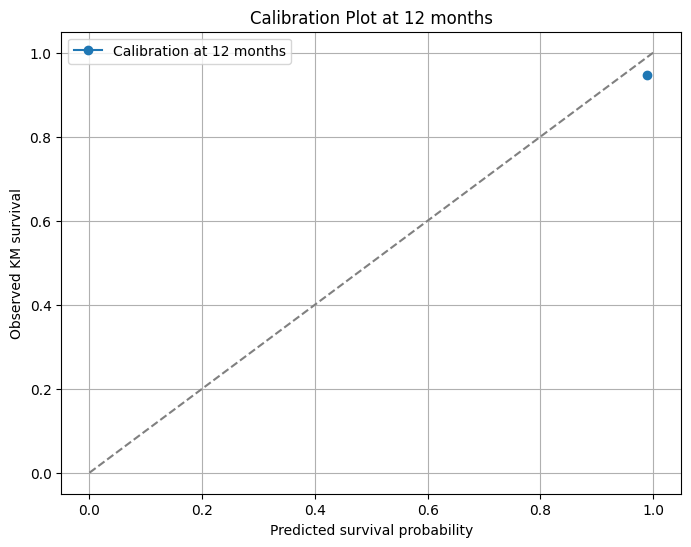

In [58]:
# Assuming you have already created the y_test_struct object
# Correct function call:
calibration_plot(wbf, X_test_filtered, y_test_struct, fixed_time=12, n_bins=5, is_pycox=False)